In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary
from torcheval.metrics import BinaryPrecisionRecallCurve
import torchmetrics
from tqdm.notebook import tqdm
from torchmetrics import R2Score
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from comet_ml import Experiment

%matplotlib inline

C:\Users\Администратор\AppData\Roaming\Python\Python310\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
df=pd.read_csv('datasets/data.csv')
df[['q_mu', 'q_nu1', 'q_nu2', 'e_nu_1', 'e_nu_2']]

,q_mu,q_nu1,q_nu2,e_nu_1,e_nu_2
0,0.550377,0.164911,0.008094,0.01904,0.17794
1,0.564295,0.167629,0.006639,0.01672,0.20868
2,0.564179,0.164110,0.007052,0.01337,0.20442
3,0.573555,0.167174,0.006663,0.01637,0.18453
4,0.569296,0.169658,0.006823,0.01783,0.11478
...,...,...,...,...,...
184845,0.566484,0.172819,0.008164,0.02085,0.25589
184846,0.572031,0.170474,0.007907,0.01592,0.23668
184847,0.569204,0.173147,0.007366,0.01590,0.24216
184848,0.570114,0.168854,0.007378,0.01384,0.24447


In [4]:
data=np.log(df['e_mu_current'])
data_std=np.std(data)
data_mean=np.mean(data)

labels=[]

for point in data:
    if point >=2*data_std+data_mean:
        labels.append(1)
    else:
        labels.append(0)

labels=np.array(labels)

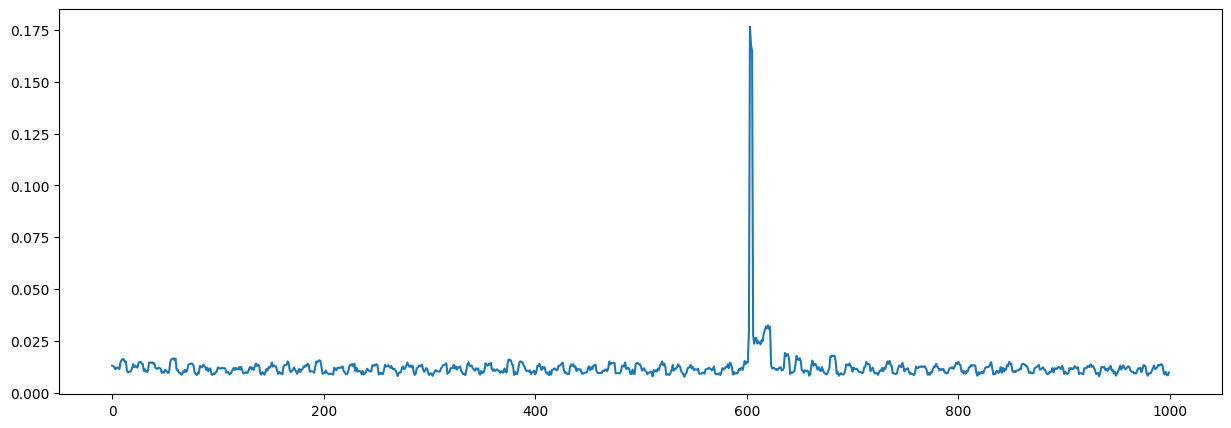

In [9]:
plt.figure(figsize=(15,5))
plt.plot(np.exp(data[:1000]))

In [ ]:
class BoxDataset(Dataset):
    
    @classmethod
    def __init__(self, df_path):
        self.data=pd.read_csv(df_path)
        self.x = self.data[['q_mu', 'q_nu1', 'q_nu2', 'e_nu_1', 'e_nu_2']].values
        labels=[]
        self.matrices=[]
        
        log_data=np.log(self.data['e_mu_current'])
        data_std=np.std(log_data)
        data_mean=np.mean(log_data)

        for i, point in enumerate(log_data[5:-1]):
            if point >=2*data_std+data_mean:
                labels.append(1)
            else:
                labels.append(0)
            self.matrices.append(self.x[i:5+i,:])
            
        self.labels=np.array(labels)
        
        self.labels = torch.FloatTensor(self.labels)
        self.matrices = torch.FloatTensor(self.matrices)
    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        return {'matrices':self.matrices[idx], 'labels':self.labels[idx]}

In [ ]:
dataset=BoxDataset(df_path='datasets/data.csv')

val_sptit = 0.2
batch_size = 1024

train_len = len(dataset) - int(len(dataset) * val_sptit)
test_len = int(len(dataset) * val_sptit)

train_set, val_set = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          drop_last=True)
test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                         drop_last=True)

In [ ]:
class Net(nn.Module):
    def __init__(self,in_channels=1):
        super(Net, self).__init__()
        
        self.relu = nn.LeakyReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16,kernel_size=(3, 3))
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3, 3))
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3, 3))
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(2, 2))
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1_1 = nn.Linear(in_features=32, out_features=256)
        self.anomaly = nn.Linear(in_features=256, out_features=1)


        for tensor in [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1_1, self.anomaly]:
            torch.nn.init.kaiming_uniform_(tensor.weight)

    def forward(self, x):
        # x = torch.fft.fft2(x).imag
        # print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        # x = self.maxpool1(x)

        # x = torch.fft.fft2(x).real

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        # x = self.maxpool2(x)

        # x = torch.fft.fft2(x).real
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.batch_norm3(x)
#         # x = self.maxpool3(x)

#         x = self.conv4(x)
#         x = self.relu(x)
#         x = self.batch_norm4(x)
        # x = self.maxpool3(x)

        x = torch.flatten(x, 1)

        output1_1 = self.fc1_1(x)
        anomaly = self.anomaly(output1_1)
        anomaly=nn.Sigmoid()(anomaly)

        return anomaly

In [ ]:
model = Net()

res = model.cuda()
summary(model, (1, 5, 5))

In [ ]:
# log=False
log=True
if log==True:
    experiment = Experiment(
        api_key="5skWtD5KzMcU6rVhVNOLfQZ6E",
        project_name="qber-nn",
        workspace="dkagramanyan",
    )

device = 'cuda'
# device = 'cpu'

model.train()
model.to(device)

learning_rate = 0.001
# learning_rate = 0.1 * (batch_size / 256)
print('lr=', learning_rate)

bce_loss = torch.nn.BCEWithLogitsLoss()
precision_recall_1 = BinaryPrecisionRecallCurve()

acc_metric=torchmetrics.classification.MulticlassAccuracy(num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

epochs_cnt = 10000
tbar = tqdm(range(epochs_cnt), leave=True, desc='?')


for epoch in tbar:

    for i, frames_series in enumerate(train_loader):

        matrices = frames_series['matrices'].to(device)
        anomaly_true = frames_series['labels'].to(device)
        m=torch.reshape(matrices, (batch_size, 1, 5, 5))

        anomaly_output = model(m)
        
        # BCE change point classification
        loss = bce_loss(torch.squeeze(anomaly_output), anomaly_true).to(device)

        # Precision@recall metrics
        precision, recall, threshold=precision_recall_1.update(anomaly_output.squeeze(), anomaly_true).compute()
        precision_recall_1_metrics=precision[torch.where(recall==1)[0][-1]]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if log==True:
            experiment.log_metric('Train loss', loss.item())
            # experiment.log_metric('Train Precision@Recall=1', precision_recall_1_metrics)
            
    if epoch % 5 == 0:
        msg = f'Train Epoch: {epoch + 1}/{epochs_cnt}\tStep: {i + 1}/{n_total_steps}\tLoss: {loss.item():.5f}\t\tPrecision@Recall=1: {precision_recall_1_metrics:.4f}'

        # print(msg)



    if epoch % 5 == 0:
        with torch.no_grad():
            r2score = R2Score().to(device)

            loss_list=[]
            rotate_loss_list=[]
            change_point_type_loss_list=[]
            change_point_loss_list=[]

            precision_recall_1_metrics_list=[]
            f_1_metrics_list=[]



            for j, test_frames_series in enumerate(test_loader):
                matrices = test_frames_series['matrices'].to(device)
                anomaly_true = test_frames_series['labels'].to(device)
                m=torch.reshape(matrices, (batch_size, 1, 5, 5))

                anomaly_output = model(m)

                # BCE change point classification
                loss = bce_loss(torch.squeeze(anomaly_output), anomaly_true).to(device)

                # Precision@recall metrics
                precision, recall, threshold=precision_recall_1.update(anomaly_output.squeeze(), anomaly_true).compute()
                precision_recall_1_metrics=precision[torch.where(recall==1)[0][-1]]
                precision_recall_1_metrics_list.append(precision_recall_1_metrics)
                
                f_1_metrics=f1_score(anomaly_output.squeeze().detach().cpu().numpy()==1,
                                     anomaly_true.detach().cpu().numpy())
                f_1_metrics_list.append(f_1_metrics)


                loss_list.append(loss)

            loss_v=torch.mean(torch.FloatTensor(loss_list))

            precision_recall_1_metrics_v=torch.mean(torch.FloatTensor(precision_recall_1_metrics_list)).to(device)
            f_1_metrics_v=torch.mean(torch.FloatTensor(f_1_metrics_list)).to(device)



            msg = f'\n Test Loss: {loss_v:.4f}\tPrecision@Recall=1: {precision_recall_1_metrics_v:.4f}\tAnomaly type F_1: {f_1_metrics_v:.6f}'

            print(msg)
            if log==True:
                experiment.log_metric('Test loss', loss_v)
                experiment.log_metric('Test Precision@Recall=1', precision_recall_1_metrics_v)
                experiment.log_metric('Test Anomaly F_1', f_1_metrics_v)



In [ ]:
experiment.end()

In [ ]:
f1_score(anomaly_output.squeeze().detach().cpu().numpy()==1,
         anomaly_true.detach().cpu().numpy())
                